In [ ]:
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

# Ignore warnings from specific modules or categories
warnings.filterwarnings("ignore", category=ImportWarning, module="pickle")  # Adjust as needed

In [2]:
df = pd.read_csv('diseaseandsymptoms.csv')

df.head()

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print("Unique target classes:", df['diseases'].nunique())
print("Target distribution:\n", df['diseases'].value_counts())

Unique target classes: 773
Target distribution:
 diseases
cystitis                          1219
nose disorder                     1218
vulvodynia                        1218
complex regional pain syndrome    1217
spondylosis                       1216
                                  ... 
open wound of the head               1
myocarditis                          1
chronic ulcer                        1
hypergammaglobulinemia               1
kaposi sarcoma                       1
Name: count, Length: 773, dtype: int64


In [4]:
df.shape
df.dtypes
df.isnull().sum()

diseases                            0
anxiety and nervousness             0
depression                          0
shortness of breath                 0
depressive or psychotic symptoms    0
                                   ..
hip weakness                        0
back swelling                       0
ankle stiffness or tightness        0
ankle weakness                      0
neck weakness                       0
Length: 378, dtype: int64

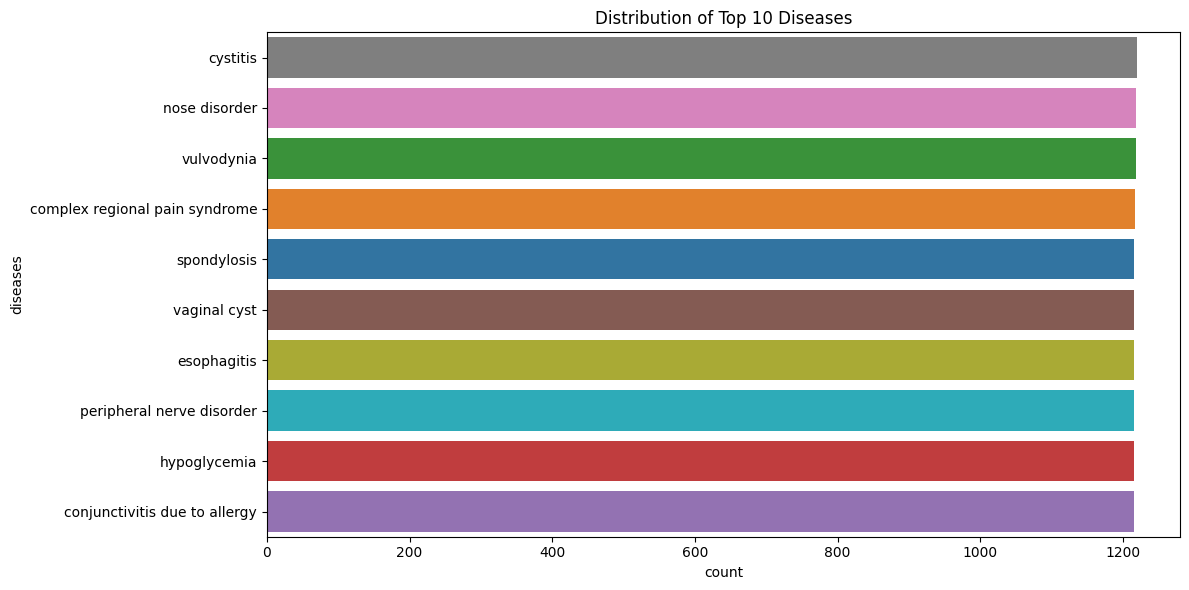

In [5]:
#the top 10 diseases
top_diseases = df['diseases'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 diseases
top_df = df[df['diseases'].isin(top_diseases)]

# Visualization
plt.figure(figsize=(12, 6))
sns.countplot(data=top_df, y='diseases', hue='diseases', order=top_diseases)
plt.title("Distribution of Top 10 Diseases")
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd

def find_outliers_iqr(data, column):
    """
    Finds outliers in a DataFrame column using the IQR method.
    Modified to handle categorical data by skipping outlier calculation.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The name of the column to check for outliers.

    Returns:
        pd.Series: A Series containing the outliers, or an empty Series if the
                   column is categorical.
    """
    if data[column].dtype == 'object':  # Check if the column is categorical
        print(f"Skipping outlier calculation for categorical column: {column}")
        return pd.Series(dtype=object)  # Return empty Series
    else:
        # Calculate quantiles and IQR
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate upper and lower bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]

        return outliers

# Assuming your DataFrame is named 'df' and the column you want to check is 'your_column'
outliers = find_outliers_iqr(df, 'diseases')

print("Outliers:", outliers)

Skipping outlier calculation for categorical column: diseases
Outliers: Series([], dtype: object)


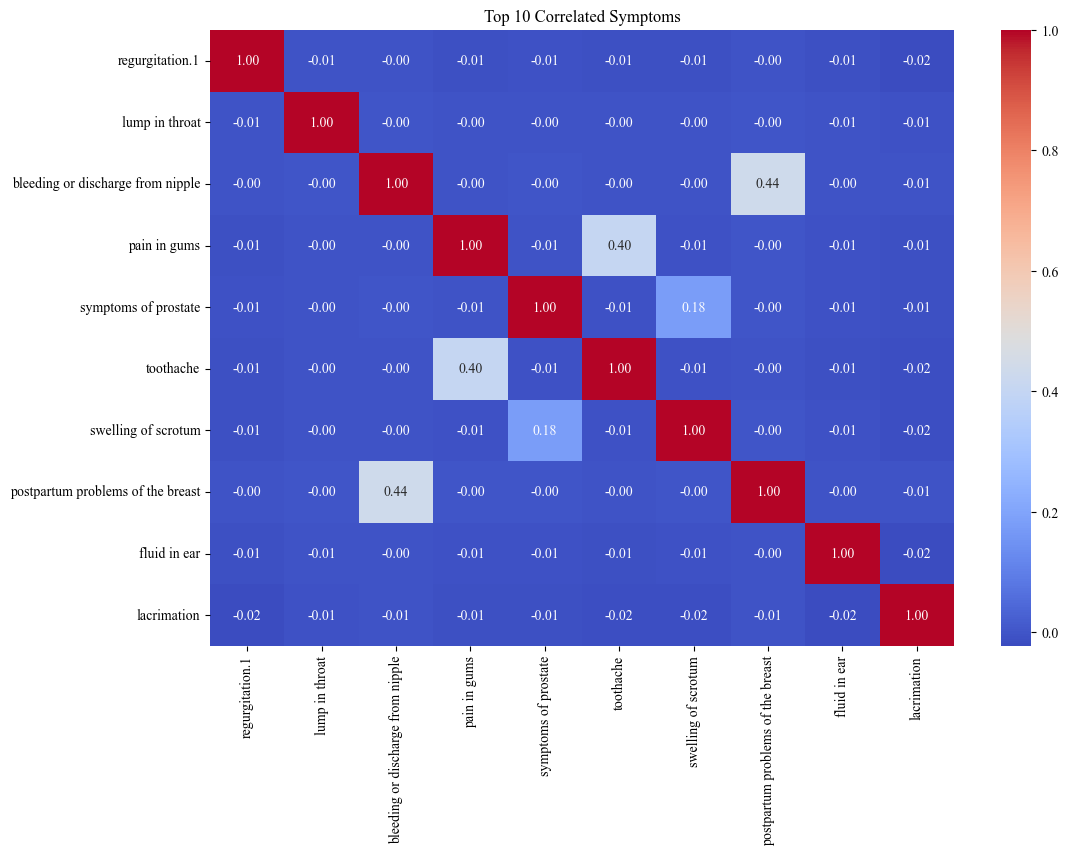

In [7]:
# Correlation Heatmap
corr_matrix = df.drop(columns='diseases').corr()

# Get the absolute values of correlations
corr_matrix = corr_matrix.abs()

# Get the top 10 correlated symptoms
top_10_corr = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates()
top_10_corr = top_10_corr[top_10_corr < 1][:10]

# Get the names of the top 10 correlated symptoms
# Extract individual symptom names from tuples
top_10_symptoms = [symptom[0] for symptom in top_10_corr.index]

# Extract the relevant columns from the original DataFrame
top_10_df = df[top_10_symptoms]


# Set the global font family for Matplotlib
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_10_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 10 Correlated Symptoms")  # Font family is already set globally
plt.xticks()  # Font family is already set globally
plt.yticks()  # Font family is already set globally
plt.show()

<ipython-input-26-727643e7110d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_symptoms.values, y=top_symptoms.index, palette="viridis")


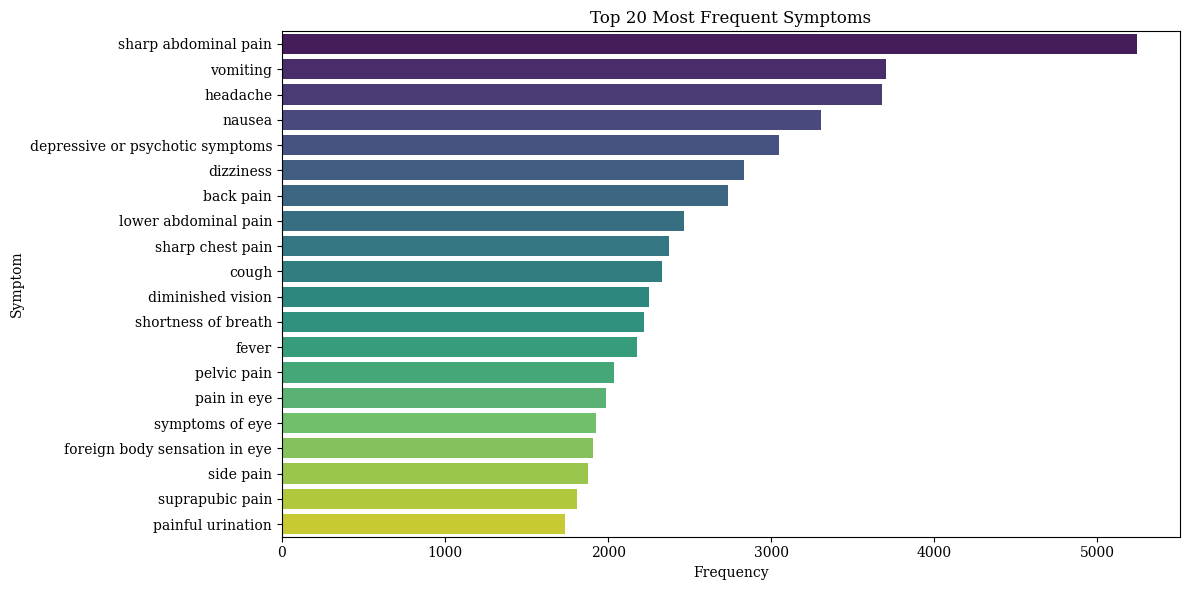

In [ ]:
# Top 20 most frequent symptoms across all rows
symptom_sums = df.drop(columns='diseases').sum().sort_values(ascending=False)
top_symptoms = symptom_sums.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_symptoms.values, y=top_symptoms.index, palette="viridis")
plt.title("Top 20 Most Frequent Symptoms")
plt.xlabel("Frequency")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()

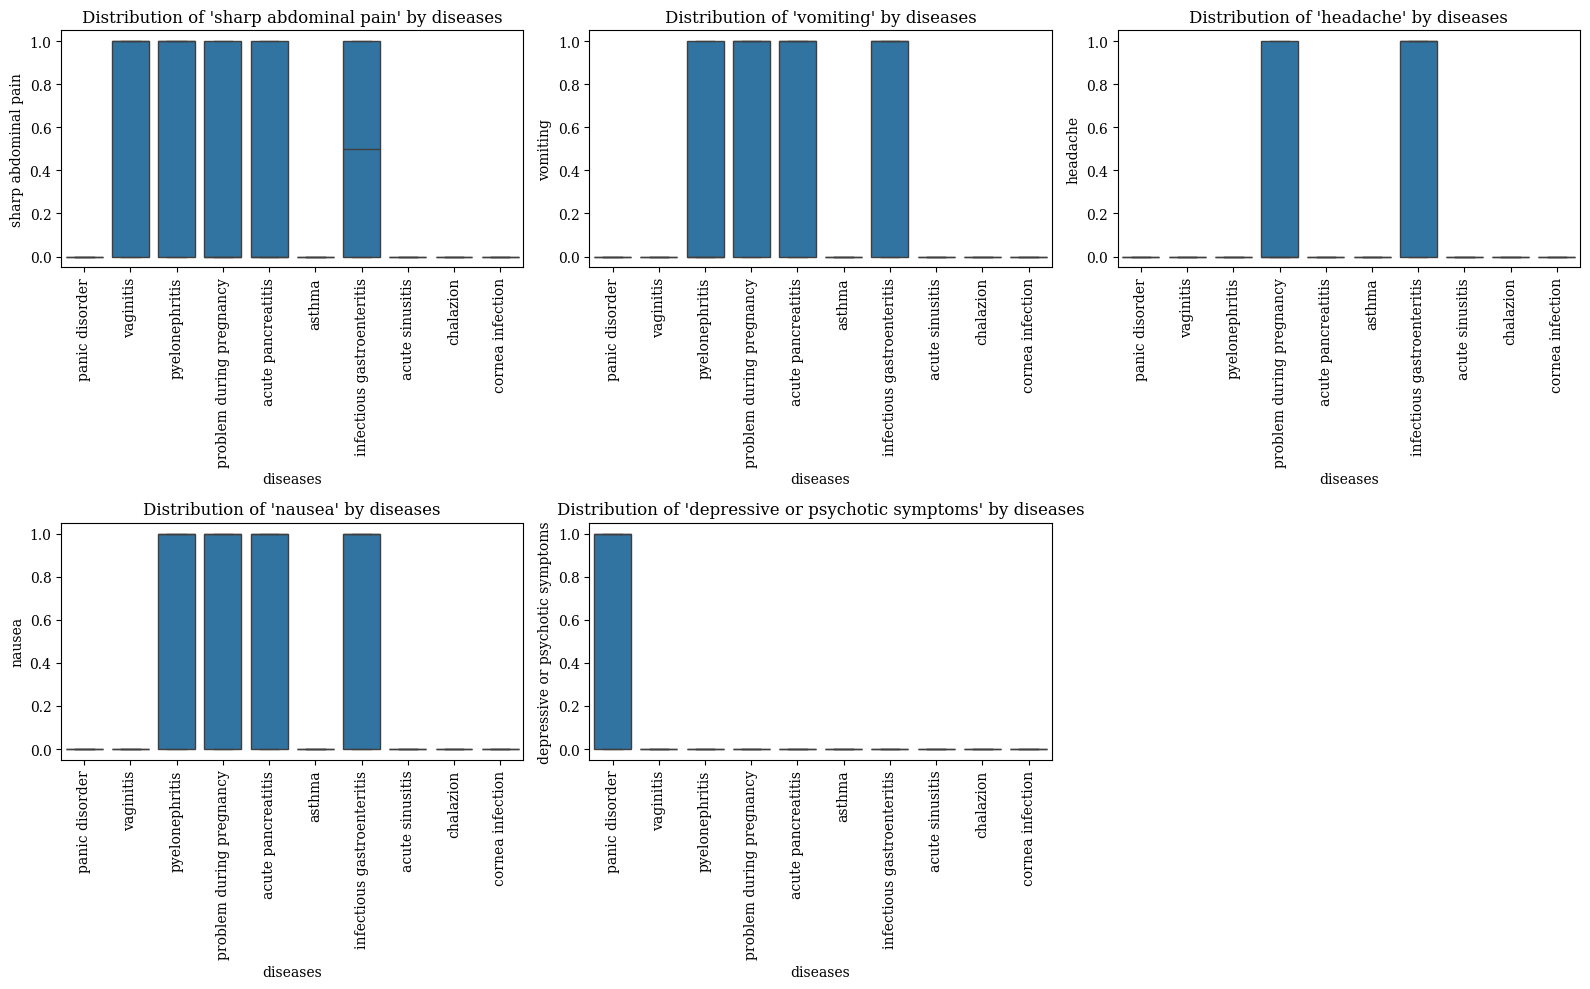

In [ ]:
# Box plots for top 5 most frequent symptoms grouped by prognosis

# Select top 5 frequent symptoms and top 10 prognosis classes
top_5_symptoms = symptom_sums.head(5).index
top_10_diseases = df['diseases'].value_counts().head(10).index

# Filter dataset for top 10 prognosis
df_top = df[df['diseases'].isin(top_10_diseases)]

# Plot box plots
plt.figure(figsize=(16, 10))
for i, symptom in enumerate(top_5_symptoms, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='diseases', y=symptom, data=df_top)
    plt.xticks(rotation=90)
    plt.title(f"Distribution of '{symptom}' by diseases")

plt.tight_layout()
plt.show()


In [9]:
# Split features and target
X = df.drop(columns='diseases')
y = df['diseases']

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.impute import SimpleImputer

# Create an imputer to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like 'median' or 'most_frequent'

# Fit the imputer on your training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)





In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder on all unique target labels from both training and testing sets
all_labels = pd.concat([y_train, y_test]).unique()  # Combine and get unique labels
label_encoder.fit(all_labels)  # Fit on all unique labels

# Transform both training and testing labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize all models including XGBoost
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=42)  # Add XGBoost here
}

# Train and evaluate each model using encoded labels
results = {}

for name, model in models.items():
    model.fit(X_train_imputed, y_train_encoded)  # Train with encoded labels
    y_pred_encoded = model.predict(X_test_imputed)  # Predict on the test set

    # Convert predictions back to original labels for evaluation
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Calculate evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

    # Print results for each model
    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print("-" * 20)  # Separator

# View results summary
print("\nSummary of Model Accuracies:")
for name, metrics in results.items():  # Changed acc to metrics to access all metrics
    print(f"{name}: {metrics['Accuracy']:.4f}")

C:\Users\suhai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\suhai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression:
  Accuracy: 0.8655
  Precision: 0.8734
  Recall: 0.8655
  F1-Score: 0.8652
--------------------


MemoryError: could not allocate 803209216 bytes

: 

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids
param_grids = {
    'Logistic Regression': {  # Added for Logistic Regression
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],  # Regularization type
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
}



models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Perform Grid Search
best_estimators = {}
from sklearn.metrics import accuracy_score

for name in models:
    print(f"\n🔧 Tuning {name}...")
    grid = GridSearchCV(models[name], param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_imputed, y_train)
    best_estimators[name] = grid.best_estimator_
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Best Params: {grid.best_params_}")
    print(f"🎯 Accuracy after tuning: {acc:.4f}")


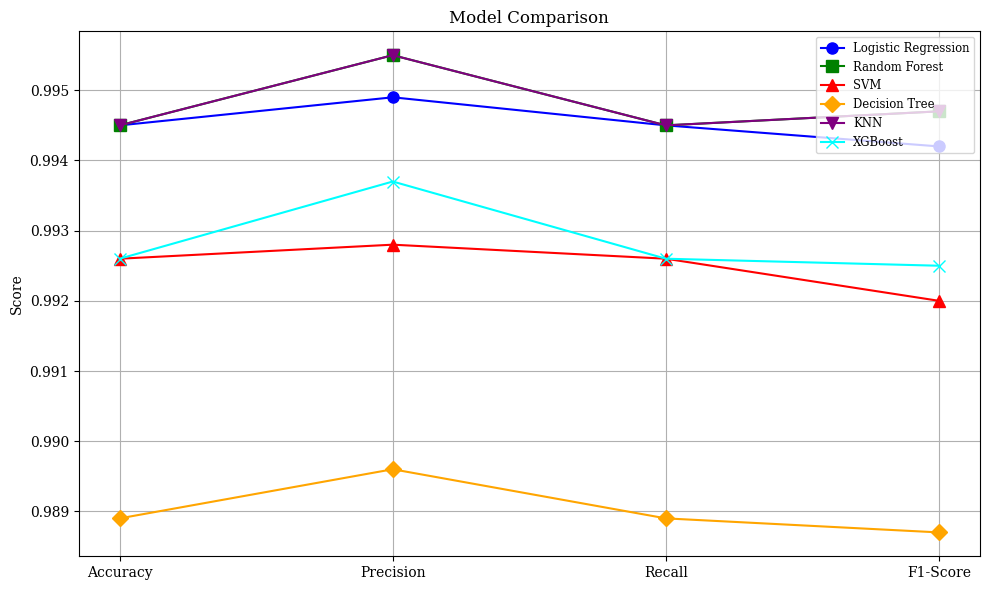

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def model_comparison_graph(results):
    """
    Generates a graph comparing the performance of different models across multiple metrics using points.

    Args:
        results (dict): A dictionary where keys are model names and values are dictionaries of metrics (e.g., accuracy, precision).
    """

    metrics = list(results[list(results.keys())[0]].keys())
    num_models = len(results)
    num_metrics = len(metrics)

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan']
    markers = ['o', 's', '^', 'D', 'v', 'x']


    fig, ax = plt.subplots(figsize=(10, 6))


    x_pos = np.arange(len(metrics))

    for i, model in enumerate(results.keys()):
        y_values = [results[model][metric] for metric in metrics]
        ax.plot(x_pos, y_values, color=colors[i % len(colors)], marker=markers[i % len(markers)],
                linestyle='-', label=model, markersize=8)

    ax.set_ylabel('Score')
    ax.set_title('Model Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(metrics)
    ax.legend(loc='upper right', fontsize='small')
    ax.grid()

    plt.tight_layout()
    plt.show()


results = {
    "Logistic Regression": {'Accuracy': 0.9945, 'Precision': 0.9949, 'Recall': 0.9945, 'F1-Score': 0.9942},
    "Random Forest": {'Accuracy': 0.9945, 'Precision': 0.9955, 'Recall': 0.9945, 'F1-Score': 0.9947},
    "SVM": {'Accuracy': 0.9926, 'Precision': 0.9928, 'Recall': 0.9926, 'F1-Score': 0.9920},
    "Decision Tree": {'Accuracy': 0.9889, 'Precision': 0.9896, 'Recall': 0.9889, 'F1-Score': 0.9887},
    "KNN": {'Accuracy': 0.9945, 'Precision': 0.9955, 'Recall': 0.9945, 'F1-Score': 0.9947},
    "XGBoost": {'Accuracy': 0.9926, 'Precision': 0.9937, 'Recall': 0.9926, 'F1-Score': 0.9925}
}


model_comparison_graph(results)

In [ ]:
# Initialize all models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=200, random_state=42),
    "SVM": SVC(C=0.1, kernel='linear'),
    "XGBoost": XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, eval_metric='mlogloss', random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3, weights='uniform')
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    # Use encoded labels for training XGBoost
    if name == "XGBoost":
        model.fit(X_train_imputed, y_train_encoded)
    else:
        model.fit(X_train_imputed, y_train)  # Use original labels for other models

    y_pred = model.predict(X_test_imputed)  # Assuming you want to predict on the imputed test data

    # If XGBoost, inverse transform the predictions
    if name == "XGBoost":
        y_pred = label_encoder.inverse_transform(y_pred)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: Accuracy = {acc:.4f}")

# View results summary
print("\nSummary of Model Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

Logistic Regression: Accuracy = 0.9662
Random Forest: Accuracy = 0.8146
SVM: Accuracy = 0.9612
XGBoost: Accuracy = 0.9416
Decision Tree: Accuracy = 0.9406
KNN: Accuracy = 0.9525

Summary of Model Accuracies:
Logistic Regression: 0.9662
Random Forest: 0.8146
SVM: 0.9612
XGBoost: 0.9416
Decision Tree: 0.9406
KNN: 0.9525


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_imputed)
    if name == "XGBoost":  # If XGBoost, inverse transform predictions
        y_pred = label_encoder.inverse_transform(y_pred)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    avg_metric = (acc + precision + recall + f1) / 4

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Avg Metric': avg_metric
    })

results_df = pd.DataFrame(results)
print("\nModel Evaluation Summary:")
print(results_df)

# Find the best model based on 'Avg Metric' (you can change this)
best_model_name = results_df.loc[results_df['Avg Metric'].idxmax(), 'Model']
print(f"\n🏆 The best model based on Avg Metric is: {best_model_name}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Model Evaluation Summary:
                 Model  Accuracy  Precision    Recall  F1 Score  Avg Metric
0  Logistic Regression  0.966192   0.967354  0.966192  0.966032    0.966443
1        Random Forest  0.814561   0.844742  0.814561  0.801464    0.818832
2                  SVM  0.961172   0.962866  0.961172  0.960003    0.961303
3              XGBoost  0.941590   0.943154  0.941590  0.940121    0.941614
4        Decision Tree  0.940586   0.942398  0.940586  0.940491    0.941015
5                  KNN  0.952469   0.953604  0.952469  0.952383    0.952731

🏆 The best model based on Avg Metric is: Logistic Regression


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import pickle
import gc
import numpy as np

# Create a DataFrame to store results (without the actual model objects)
results = []
best_score = 0
best_model_name = None

# Process one model at a time to save memory
for name, model in models.items():
    print(f"Processing {name}...")
    
    # Check if model is fitted, if not, fit it
    try:
        # This will raise exception if model is not fitted
        model.predict(X_test_imputed[:1])
    except:
        print(f"Fitting {name}...")
        model.fit(X_train_imputed, y_train)
    
    # Predict in smaller batches if dataset is very large
    batch_size = 10000  # Adjust based on your available RAM
    if len(X_test_imputed) > batch_size:
        y_pred = []
        for i in range(0, len(X_test_imputed), batch_size):
            batch_pred = model.predict(X_test_imputed[i:i+batch_size])
            y_pred.extend(batch_pred)
        y_pred = np.array(y_pred)
    else:
        y_pred = model.predict(X_test_imputed)
    
    # Handle XGBoost predictions if needed
    if name == "XGBoost":
        y_pred = label_encoder.inverse_transform(y_pred)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    avg_metric = (acc + precision + recall + f1) / 4
    
    # Store results (without the model object)
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Avg Metric': avg_metric
    })
    
    # Check if this is the best model so far
    if avg_metric > best_score:
        best_score = avg_metric
        best_model_name = name
        
        # Save the best model immediately and remove previous best if it exists
        filename = f"{name.replace(' ', '_')}.pkl"
        print(f"Saving new best model: {name} (score: {avg_metric:.4f})")
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
    
    # Force garbage collection after each model
    del y_pred
    gc.collect()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df.sort_values('Avg Metric', ascending=False))

print(f"\n✅ Best model '{best_model_name}' saved to '{best_model_name.replace(' ', '_')}.pkl'")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.